In [1]:
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np
import os, random
import time
from PIL import Image
import copy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass

# Loading data

Competition data

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Data transformations for data augmentation
jitter_param = 0.02
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomRotation(degrees=(-5,5), 
                                  resample=False, 
                                  expand=False, 
                                  center=None, 
                                  fill=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.556, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(544),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.556, 0.406], [0.229, 0.224, 0.225])
    ])

#We define the dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img.to(device), label.to(device)
    
    def check(self):
        if len(self.img) == len(self.labels):
            print('Okey!')
        else:
            print('imgs and labels different len')

#Take train data and create a dataset class with it
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')
#imgs = [database_base_path + 'train_images/' + img for img in os.listdir(database_base_path)]

#Shuffle data
df = df.sample(frac=1)

#Take imgs and labels
imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values



In [4]:
#Hyperparameters. train_val_split means the fraction of images intended for train (max value=1)
train_val_split = 0.85
batch_size = 12

train_dataset = Dataset(imgs[0:int(train_val_split*len(imgs))], 
                        labels[0:int(train_val_split*len(imgs))], 
                        train_transform)
val_dataset = Dataset(imgs[int(train_val_split*len(imgs)):len(imgs)], 
                      labels[int(train_val_split*len(imgs)):len(imgs)], 
                      val_transform)

#create the dataloaders



Extra data

In [5]:
data_dir = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/extra'
directory = data_dir + '/train/'
folders = [directory + filename for filename in os.listdir(directory)]

In [6]:
img_cbb = [folders[0] + '/' + filename for filename in os.listdir(folders[0])]
cbb = 0

img_cbsd = [folders[1] + '/' + filename for filename in os.listdir(folders[1])]
cbsd = 1

img_cgm = [folders[2] + '/' + filename for filename in os.listdir(folders[2])]
cgm = 2

img_cmd = [folders[3] + '/' + filename for filename in os.listdir(folders[3])]
cmd = 3

img_healthy = [folders[4] + '/' + filename for filename in os.listdir(folders[4])]
healthy = 4

In [7]:
cbb_dataset = Dataset(img_cbb, 
                        np.zeros((len(img_cbb))), 
                        train_transform)
cbsd_dataset = Dataset(img_cbsd, 
                        np.ones((len(img_cbsd))), 
                        train_transform)
cgm_dataset = Dataset(img_cgm, 
                        np.ones((len(img_cgm)))*2, 
                        train_transform)
cmd_dataset = Dataset(img_cmd, 
                        np.ones((len(img_cmd)))*3, 
                        train_transform)
healthy_dataset = Dataset(img_healthy, 
                        np.ones((len(img_healthy)))*4, 
                        train_transform)

Concat Datasets

In [8]:
full_data = torch.utils.data.ConcatDataset([train_dataset, 
                                            cbb_dataset, 
                                            cbsd_dataset, 
                                            cgm_dataset, 
                                            cmd_dataset, 
                                            healthy_dataset])

train_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size, 
                                           shuffle=True, num_workers=4,pin_memory=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4,pin_memory=True)
dataloader = []
dataloader.append(train_loader)
dataloader.append(validation_loader)

dataset_sizes = []
dataset_sizes.append(len(full_data))
dataset_sizes.append(len(val_dataset))
print(dataset_sizes)

[23843, 3210]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

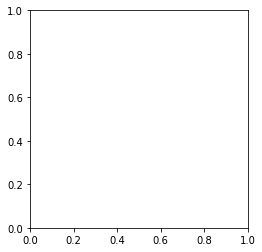

In [9]:
plt.imshow(full_data.__getitem__(10)[0].permute(1, 2, 0))
full_data.__getitem__(23000)[1]

# Loading model

In [9]:
#Load trained model to re-train
model = torch.load('/media/sergio/traballos sergio/msi/models/cassava/VGG16-1.h5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
#Load ResNet50 new model

model = torchvision.models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
#Load wide-Resnet101
model = torchvision.models.wide_resnet101_2(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [9]:
#Load vgg16 new model

model = torchvision.models.vgg16(pretrained=True)
model.classifier.add_module('7', nn.ReLU())
model.classifier.add_module('8', nn.Dropout(p=0.5, inplace=False))
model.classifier.add_module('9', nn.Linear(1000, 5))
model.classifier.add_module('10', nn.LogSoftmax(dim=1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train

In [11]:
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    losses = np.zeros((2,num_epochs))
    acertos= np.zeros((2,num_epochs))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

       
        for phase in range(2):
            if phase == 0:
                model.train()  # Pon a rede en training mode
            else:
                model.eval()   # Pon a rede en evaluate mode

            running_loss = 0.0
            running_corrects = 0
            itera = 0
          
            for inputs, labels in dataloader[phase]:
                inputs = inputs
                labels = labels
                
                itera += 1
                if itera%1000 == 0:
                    print('batch:', itera)
                    
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 0):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 0:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 0:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 0:
              losses[0, epoch]= epoch_loss
              acertos[0, epoch]= epoch_acc
            else:
              losses[1, epoch]= epoch_loss
              acertos[1, epoch]= epoch_acc

            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('train loss:', list(losses[0]))
    print()
    print('val loss:', list(losses[1]))
    print()
    print('train acc:', list(acertos[0]))
    print()
    print('val acc:', list(acertos[1]))
    # Cargamos os mellores pesos obtidos ao longo das iteracións
    model.load_state_dict(best_model_wts)
    return model, losses, acertos

In [12]:
criterion = nn.CrossEntropyLoss()

#lr = 0.00015 #vgg-16
lr = 0.001 #resnet50
#lr = 0.00005
optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.8)   #SGD
#optimizer_ft = torch.optim.Adam(model.parameters(), lr=lr)         #ADAM

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [ ]:
best_model, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


In [22]:
print(loss1)
print(accuracy1)

[[0.47723032 0.46148194]
 [0.66532305 0.55669564]]
[[0.84209202 0.84859288]
 [0.82180685 0.86105919]]


In [ ]:
accuracy1 = acc
loss1 = loss

In [21]:
acc2 = np.concatenate(accuracy1, acc)
loss2 = np.concatenate(loss1, loss)

TypeError: only integer scalar arrays can be converted to a scalar index

In [37]:
train_acc=np.array([69, 79.2, 82.9, 83.5, 84.1, 84.2, 84.2, 84.86, 84.96, 85.4])
test_acc=np.array([84.1, 73, 82.1, 83.8, 83., 85, 82.2, 86.1, 82.6, 85.5 ])
train_loss=np.array([0.9,0.61,0.52,0.49,0.48,0.47, 0.47723032, 0.46148194, 0.4547, 0.4392])
test_loss=np.array([0.55, 0.99, 0.7, 0.65, 0.62, 0.6, 0.66532305, 0.55669564, 0.6774, 0.5491])

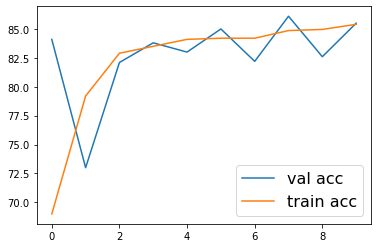

In [38]:
plt.plot(np.arange(0,test_acc.shape[0],1), test_acc, label='val acc')
plt.plot(np.arange(0,train_acc.shape[0],1), train_acc, label='train acc')
plt.legend(loc=0, prop={'size': 16})

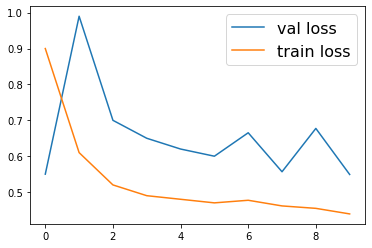

In [39]:
plt.plot(np.arange(0,test_acc.shape[0],1), test_loss, label='val loss')
plt.plot(np.arange(0,train_acc.shape[0],1), train_loss, label='train loss')
plt.legend(loc=0, prop={'size': 16})

# Results

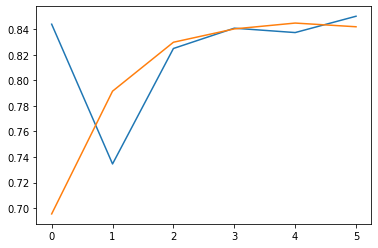

In [13]:
plt.plot(np.arange(0,acc.shape[1],1), acc[1], label='val acc')
plt.plot(np.arange(0,acc.shape[1],1), acc[0], label='train acc')

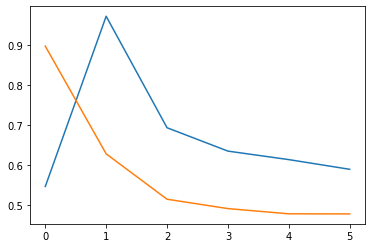

In [14]:
plt.plot(np.arange(0,loss.shape[1],1), loss[1], label='val acc')
plt.plot(np.arange(0,loss.shape[1],1), loss[0], label='train acc')

In [33]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/wide-resnet101.h5'
torch.save(model, PATH)

In [ ]:
PATH='/media/sergio/traballos sergio/msi/models/cassava/VGG16-2-best.h5'
torch.save(best_model, PATH)

In [19]:
model, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
images: 1000
0 Loss: 0.4861 Acc: 0.8330
1 Loss: 0.3932 Acc: 0.8623

Epoch 1/1
----------
images: 1000
0 Loss: 0.4753 Acc: 0.8360
1 Loss: 0.4009 Acc: 0.8617

Training complete in 27m 41s
Best val Acc: 0.862305
train loss: [0.4860530502452251, 0.47531284963301507]

val loss: [0.3931747988661362, 0.4008864563196387]

train acc: [0.8329576070819816, 0.8359817452026173]

val acc: [0.8623052959501558, 0.8616822429906542]


# Semi-train 

In [4]:
#Data transformations for data augmentation
jitter_param = 0.3
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=jitter_param,
            contrast=jitter_param,
            saturation=jitter_param),
        transforms.RandomRotation(degrees=(-30,30), 
                                  resample=False, 
                                  expand=False, 
                                  center=None, 
                                  fill=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#We define the dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = Image.open(self.imgs[ix])
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def check(self):
        if len(self.img) == len(self.labels):
            print('Okey!')
        else:
            print('imgs and labels different len')

#Take train data and create a dataset class with it
database_base_path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
df = pd.read_csv(database_base_path + 'train.csv')
#imgs = [database_base_path + 'train_images/' + img for img in os.listdir(database_base_path)]

#Shuffle data
df = df.sample(frac=1)

#Take imgs and labels
imgs = [database_base_path + 'train_images/' + img for img in df['image_id'].values]
labels = df['label'].values

train_val_split = 0.85
batch_size = 6

train_dataset = Dataset(imgs[0:700], 
                        labels[0:700], 
                        train_transform)
val_dataset = Dataset(imgs[1000:1500], 
                      labels[1000:1500], 
                      val_transform)

#create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=False, num_workers=4)

dataloader = []
dataloader.append(train_loader)
dataloader.append(validation_loader)

dataset_sizes = []
dataset_sizes.append(len(train_dataset))
dataset_sizes.append(len(val_dataset))

In [5]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.75)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft, loss, acc = train_model(model, dataloader, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
0 Loss: 1.4239 Acc: 0.4914
1 Loss: 1.1418 Acc: 0.6260

Epoch 1/4
----------
0 Loss: 1.2096 Acc: 0.5743
1 Loss: 1.0764 Acc: 0.6260

Epoch 2/4
----------
0 Loss: 1.1282 Acc: 0.5800
1 Loss: 1.0208 Acc: 0.6500

Epoch 3/4
----------


KeyboardInterrupt: 

In [ ]:
last acc: [0.87507] resnet